In [73]:
import cv2
import mahotas
import imutils
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

In [74]:
#you might need to install mahotas: pip install mahotas 

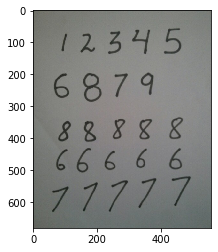

In [75]:
image = cv2.imread('test_3.jpg')

plt.imshow(imutils.opencv2matplotlib(image))
plt.show()

In [3]:
from skimage import feature

class HOG:
    def __init__(self, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3), transform=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform = transform

    def describe(self, image):
        hist = feature.hog(image,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            transform_sqrt=self.transform)
        return hist

In [4]:
def deskew(image, width):
    (h, w) = image.shape[:2]
    moments = cv2.moments(image)

    skew = moments['mu11'] / moments['mu02']
    M = np.float32([[1, skew, -0.5*w*skew],
                    [0, 1, 0]])
    image = cv2.warpAffine(image, M, (w, h), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    image = imutils.resize(image, width=width)

    return image

def center_extent(image, size):
    (eW, eH) = size

    if image.shape[1] > image.shape[0]:
        image = imutils.resize(image, width=eW)
    else:
        image = imutils.resize(image, height=eH)

    extent = np.zeros((eH, eW), dtype='uint8')
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX+image.shape[1]] = image

    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")
    (dX, dY) = ((size[0]//2) - cX, (size[1] // 2) - cY)
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)

    return extent

In [5]:
model = tf.keras.models.load_model('model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
hog = HOG(orientations=18, pixels_per_cell=(10,10), cells_per_block=(1,1), transform=True)

In [81]:
image = cv2.imread('test_3.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5,5), 0)
# edged = cv2.Canny(blurred, 30, 150)
# Threshold the image
# ret, edged = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY_INV)
edged = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in  cnts], key=lambda x: x[1])

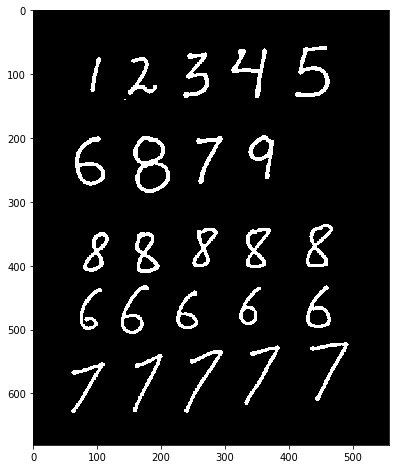

In [82]:
plt.figure(figsize=(12,8))
plt.imshow(imutils.opencv2matplotlib(edged))
plt.show()

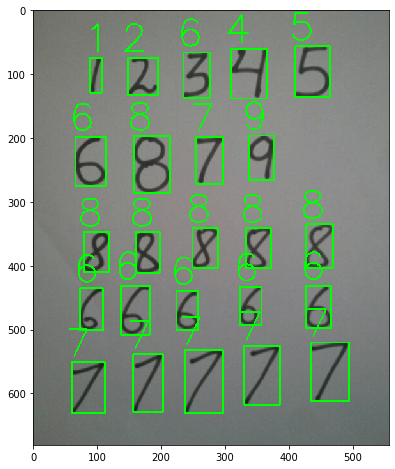

In [83]:
plt.figure(figsize=(12,8))

for (c, _) in cnts:
    (x, y, w, h) = cv2.boundingRect(c)

    if w >=7 and h>=20:
        roi = gray[y:y+h, x:x+w]
        thresh = roi.copy()
        T = mahotas.thresholding.otsu(roi)
        thresh[thresh > T] = 255
        thresh = cv2.bitwise_not(thresh)

        thresh = deskew(thresh, 28)
        thresh = center_extent(thresh, (28,28))
#         plt.imshow(thresh)
#         plt.show()

#         cv2.imshow('thresh', thresh)

#         hist = hog.describe(thresh)
#         digit = model.predict([hist])[0]
#         print("Prediction {}".format(digit))

        predictions = model.predict(np.expand_dims(thresh, axis=0))
        digit = np.argmax(predictions)

        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(image, str(digit), (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
#         cv2.imshow("image", image)
#         cv2.waitKey(0)
        plt.imshow(imutils.opencv2matplotlib(image))
plt.show()       